## Lab 4: Introduction to Convolutional Layers

Author: Ravi C, Aakash Kaku, Lee Tanenbaum

The goal of this lab is to understand how to train a convolutional neural network using PyTorch. 

The dataset we will analyze will be a small section of the nih chest xrays dataset, found here: https://www.kaggle.com/nih-chest-xrays/sample . Please create a Kaggle account to download the data.

The task at hand is to treat the dataset as a binary classification problem with image inputs. We propose to build a model that is a series of spatial convolutional layers, activation functions, and pooling layers.

Before we get into the code, lets think for a bit about model selection. What are the necessary choices?

Number of hidden layers?

For each layer:

    Number of filters?

    Size of kernel?

    Size of padding? (maybe (kernel - 1) / 2)
    
    Stride of layer?
    
    Activation after layer:
    
        Some type of relu, tanh, sigmoid?
        
        Maybe add Batch normalization before the activation function?
    
    Maybe a pooling layer instead of a convolutional layer to decrease spatial dimension?

    Learning Rate?

    Momentum parameters for optimizers such as ADAM?

Other training techniques such as adding noise to input or hidden layers?

Image specific techniques such as random rotations or blurring of the image?

Other optional enhancements:

    Let us know if you have any ideas, there are approximately infinite different enhancements that can be included to help these types of models learn
    
Before you start to write code, try to have a choice of these hyperparameters in mind so you can try to implement them

In [1]:
#Import common dependencies
import torch
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt
from PIL import Image 
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import time
import torch.nn.functional as F

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Dataset Selection

### First, read in the sample labels which we will treat as y classes, and split into train, validation and test

In [3]:
label_df = pd.read_csv('sample_labels.csv').iloc[:, :2]
label_df.head()

,Image Index,Finding Labels
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...
1,00000013_026.png,Cardiomegaly|Emphysema
2,00000017_001.png,No Finding
3,00000030_001.png,Atelectasis
4,00000032_001.png,Cardiomegaly|Edema|Effusion


In [4]:
label_df['Disease']=(label_df['Finding Labels'] != 'No Finding').astype(int)
print(label_df.head())
num_rows = 1000
label_df = label_df.iloc[:num_rows,:]

# define train, val and test idx
idx = np.arange(num_rows)
np.random.shuffle(idx)
train_size = 600
val_size = 200
test_size = 200
train_idx = idx[:train_size]
val_idx = idx[train_size:train_size+val_size]
test_idx = idx[train_size+val_size:]

# get train, val and test dataframes
train_df = label_df.iloc[train_idx,:]
val_df = label_df.iloc[val_idx,:]
test_df = label_df.iloc[test_idx,:]

# save the dataframes
train_df.to_csv('train.csv', index = False)
val_df.to_csv('val.csv', index = False)
test_df.to_csv('test.csv', index = False)

        Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Disease  
0        1  
1        1  
2        0  
3        1  
4        1  


### We build dataloader to efficiently load the images and possibly also do some data augmentation on the fly

In [5]:
class Xray_dataset(Dataset):
    '''X-ray Dataset'''
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        
        file_name = self.df.iloc[idx,0]
        label = self.df.iloc[idx,-1]
        img = Image.open('./images/'+file_name)
        img = img.resize((512, 512))
        
        if self.train:
            # rotate the image (data augementation)
            rand_num = np.random.random()
            if rand_num > 0.7:
                rot_angle = np.random.uniform(low = -10, high = 10)
                img = img.rotate(rot_angle)
                
        img = np.asarray(img)
        min_image = np.min(img)
        max_image = np.max(img)
        img = (img - min_image)/(max_image - min_image + 1e-4)
        
        img = torch.tensor(img).unsqueeze(0).float()
        label = torch.tensor(label).long()
        if img.dim() != 3:
            img = img[:,:,:,0]
        
        return img, label


In [6]:
train_df_path = './train.csv'
val_df_path = './val.csv'
test_df_path = './test.csv'
transformed_dataset = {'train': Xray_dataset(train_df_path, train = True),
                       'validate':Xray_dataset(val_df_path),
                       'test':Xray_dataset(test_df_path),
                                          }
bs = 4
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

### Check the data loader

In [7]:
sample = next(iter(dataloader['train']))

In [8]:
sample[0].size()

torch.Size([4, 1, 512, 512])

In [9]:
sample[1]

tensor([0, 0, 0, 0])

### Visualize the data

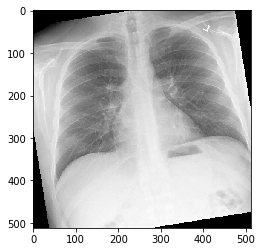

In [10]:
sample_img = sample[0][1].squeeze().numpy()
plt.imshow(sample_img, cmap = 'gray')
plt.show()

### Train loop

In [11]:
def train_model(model, dataloader, optimizer, scheduler, loss_fn, num_epochs = 10, verbose = False):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
                
            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data[0].to(device)
                label = data[1].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
            
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
            else:
                if scheduler:
                    scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict

### Evaluate Loop`

In [12]:
def evaluate_model(model, dataloader,loss_fn, phase = 'validate'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    for data in dataloader[phase]:
        image = data[0].to(device)
        label = data[1].to(device)
        output = model(image)
        loss = loss_fn(output, label)
        _, preds = torch.max(output,dim = 1)
        num_imgs = image.size()[0]
        running_correct += torch.sum(preds ==label).item()
        running_loss += loss.item()*num_imgs
        running_total += num_imgs
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    
    return accuracy, loss

### Define the model class

In [13]:
class Conv_model(nn.Module):
    def __init__(self, kernel_size = 3):
        super(Conv_model,self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size, stride = 2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16,32,kernel_size, stride = 2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(32,64,kernel_size, padding = 1, stride = 3)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64,128,kernel_size, padding = 1, stride = 3)
        self.relu4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(128,256,kernel_size)
        self.relu5 = nn.ReLU()
        
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(256, 2)
        
    def forward(self,x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.relu5(self.conv5(x))
        x = self.avg(x)
        x = self.linear(x.view(-1,256))
    
        return x

### Lets Train the model

In [14]:
model = Conv_model().to(device)

In [15]:
cel = nn.CrossEntropyLoss()

In [16]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
lambda_func = lambda epoch: 0.5 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

In [17]:
model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, scheduler, cel, num_epochs=10, verbose = True)

Epoch: 0/9
----------
Phase:train, epoch loss: 0.7040 Acc: 0.5683
Phase:validate, epoch loss: 0.6916 Acc: 0.5650
Epoch: 1/9
----------
Phase:train, epoch loss: 0.6783 Acc: 0.5950
Phase:validate, epoch loss: 0.6920 Acc: 0.5650
Epoch: 2/9
----------
Phase:train, epoch loss: 0.6779 Acc: 0.5950
Phase:validate, epoch loss: 0.6871 Acc: 0.5650
Epoch: 3/9
----------
Phase:train, epoch loss: 0.6753 Acc: 0.5950
Phase:validate, epoch loss: 0.6872 Acc: 0.5650
Epoch: 4/9
----------
Phase:train, epoch loss: 0.6752 Acc: 0.5950
Phase:validate, epoch loss: 0.6873 Acc: 0.5650
Epoch: 5/9
----------
Phase:train, epoch loss: 0.6752 Acc: 0.5950
Phase:validate, epoch loss: 0.6870 Acc: 0.5650
Epoch: 6/9
----------
Phase:train, epoch loss: 0.6751 Acc: 0.5950
Phase:validate, epoch loss: 0.6869 Acc: 0.5650
Epoch: 7/9
----------
Phase:train, epoch loss: 0.6750 Acc: 0.5950
Phase:validate, epoch loss: 0.6869 Acc: 0.5650
Epoch: 8/9
----------
Phase:train, epoch loss: 0.6750 Acc: 0.5950
Phase:validate, epoch loss: 0.

### Now lets evaluate the model

In [18]:
acc, loss = evaluate_model(model, dataloader,cel,phase = 'test')

In [19]:
acc

0.525

In [20]:
loss

0.7027403378486633

### What if we change the architecturea bit by adding [Batch Norms](https://arxiv.org/abs/1502.03167)

In [21]:
class Conv_model_bn(nn.Module):
    def __init__(self, kernel_size = 3):
        super(Conv_model_bn,self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size, stride = 2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size, stride = 2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,kernel_size, padding = 1, stride = 3)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128,kernel_size, padding = 1, stride = 3)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256,kernel_size)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(256)
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(256, 2)
        
    def forward(self,x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.avg(x)
        x = self.linear(x.view(-1,256))
    
        return x

In [22]:
model = Conv_model_bn().to(device)

In [23]:
cel = nn.CrossEntropyLoss()

In [24]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
# lambda_func = lambda epoch: 0.5 ** epoch
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

In [25]:
model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, None, cel, num_epochs=10, verbose = True)

Epoch: 0/9
----------
Phase:train, epoch loss: 0.7448 Acc: 0.5683
Phase:validate, epoch loss: 0.6856 Acc: 0.5650
Epoch: 1/9
----------
Phase:train, epoch loss: 0.6807 Acc: 0.5733
Phase:validate, epoch loss: 0.7031 Acc: 0.5850
Epoch: 2/9
----------
Phase:train, epoch loss: 0.6855 Acc: 0.5883
Phase:validate, epoch loss: 0.6840 Acc: 0.5550
Epoch: 3/9
----------
Phase:train, epoch loss: 0.6664 Acc: 0.6217
Phase:validate, epoch loss: 0.7029 Acc: 0.5850
Epoch: 4/9
----------
Phase:train, epoch loss: 0.6592 Acc: 0.6000
Phase:validate, epoch loss: 0.7131 Acc: 0.5400
Epoch: 5/9
----------
Phase:train, epoch loss: 0.6748 Acc: 0.5867
Phase:validate, epoch loss: 0.6949 Acc: 0.5650
Epoch: 6/9
----------
Phase:train, epoch loss: 0.6678 Acc: 0.5867
Phase:validate, epoch loss: 0.6829 Acc: 0.5500
Epoch: 7/9
----------
Phase:train, epoch loss: 0.6599 Acc: 0.5983
Phase:validate, epoch loss: 0.7114 Acc: 0.5300
Epoch: 8/9
----------
Phase:train, epoch loss: 0.6669 Acc: 0.5933
Phase:validate, epoch loss: 0.

In [26]:
acc, loss = evaluate_model(model, dataloader,cel,phase = 'test')

In [27]:
acc

0.55

In [28]:
loss

0.7654134511947632

## Let's try a proven CNN architecture - Inception V3

Inception v3 model architecture from [“Rethinking the Inception Architecture for Computer Vision”](https://arxiv.org/abs/1512.00567).


In [13]:
#Code taken from https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3
from __future__ import division

from collections import namedtuple
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional
from torch import Tensor

InceptionOutputs = namedtuple('InceptionOutputs', ['logits', 'aux_logits'])
InceptionOutputs.__annotations__ = {'logits': torch.Tensor, 'aux_logits': Optional[torch.Tensor]}

# Script annotations failed with _GoogleNetOutputs = namedtuple ...
# _InceptionOutputs set here for backwards compat
_InceptionOutputs = InceptionOutputs


class Inception3(nn.Module):

    def __init__(self, num_classes=2, aux_logits=False, transform_input=False,
                 inception_blocks=None):
        super(Inception3, self).__init__()
        if inception_blocks is None:
            inception_blocks = [
                BasicConv2d, InceptionA, InceptionB, InceptionC,
                InceptionD, InceptionE, InceptionAux
            ]
        assert len(inception_blocks) == 7
        conv_block = inception_blocks[0]
        inception_a = inception_blocks[1]
        inception_b = inception_blocks[2]
        inception_c = inception_blocks[3]
        inception_d = inception_blocks[4]
        inception_e = inception_blocks[5]
        inception_aux = inception_blocks[6]

        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = conv_block(1, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)
        self.Mixed_5b = inception_a(192, pool_features=32)
        self.Mixed_5c = inception_a(256, pool_features=64)
        self.Mixed_5d = inception_a(288, pool_features=64)
        self.Mixed_6a = inception_b(288)
        self.Mixed_6b = inception_c(768, channels_7x7=128)
        self.Mixed_6c = inception_c(768, channels_7x7=160)
        self.Mixed_6d = inception_c(768, channels_7x7=160)
        self.Mixed_6e = inception_c(768, channels_7x7=192)
        if aux_logits:
            self.AuxLogits = inception_aux(768, num_classes)
        self.Mixed_7a = inception_d(768)
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                stddev = m.stddev if hasattr(m, 'stddev') else 0.1
                X = stats.truncnorm(-2, 2, scale=stddev)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _transform_input(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def _forward(self, x):
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux_defined = self.training and self.aux_logits
        if aux_defined:
            aux = self.AuxLogits(x)
        else:
            aux = None
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 2048 x 1 x 1
        x = F.dropout(x, training=self.training)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux

    @torch.jit.unused
    def eager_outputs(self, x, aux):
        # type: (Tensor, Optional[Tensor]) -> InceptionOutputs
        if self.training and self.aux_logits:
            return InceptionOutputs(x, aux)
        else:
            return x

    def forward(self, x):
        x = self._transform_input(x)
        x, aux = self._forward(x)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted Inception3 always returns Inception3 Tuple")
            return InceptionOutputs(x, aux)
        else:
            return self.eager_outputs(x, aux)


class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features, conv_block=None):
        super(InceptionA, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = conv_block(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(self, in_channels, conv_block=None):
        super(InceptionB, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

    def _forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(self, in_channels, channels_7x7, conv_block=None):
        super(InceptionC, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):

    def __init__(self, in_channels, conv_block=None):
        super(InceptionD, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

    def _forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):

    def __init__(self, in_channels, conv_block=None):
        super(InceptionE, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes, conv_block=None):
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [14]:
model = Inception3().to(device)
cel = nn.CrossEntropyLoss()

In [15]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
lambda_func = lambda epoch: 0.8 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

In [16]:
model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, scheduler, cel, num_epochs=10, verbose = True)

Epoch: 0/9
----------
Phase:train, epoch loss: 1.4099 Acc: 0.4933
Phase:validate, epoch loss: 9.9139 Acc: 0.5150
Epoch: 1/9
----------
Phase:train, epoch loss: 1.0523 Acc: 0.5400
Phase:validate, epoch loss: 0.7751 Acc: 0.5050
Epoch: 2/9
----------
Phase:train, epoch loss: 0.9305 Acc: 0.5300
Phase:validate, epoch loss: 1.7685 Acc: 0.5400
Epoch: 3/9
----------
Phase:train, epoch loss: 0.8090 Acc: 0.5567
Phase:validate, epoch loss: 0.8798 Acc: 0.5050
Epoch: 4/9
----------
Phase:train, epoch loss: 0.8665 Acc: 0.5450
Phase:validate, epoch loss: 0.7438 Acc: 0.5250
Epoch: 5/9
----------
Phase:train, epoch loss: 0.7395 Acc: 0.5417
Phase:validate, epoch loss: 0.7991 Acc: 0.4950
Epoch: 6/9
----------
Phase:train, epoch loss: 0.7610 Acc: 0.5567
Phase:validate, epoch loss: 1.1753 Acc: 0.4950
Epoch: 7/9
----------
Phase:train, epoch loss: 0.7431 Acc: 0.5617
Phase:validate, epoch loss: 1.0541 Acc: 0.5150
Epoch: 8/9
----------
Phase:train, epoch loss: 0.7486 Acc: 0.5467
Phase:validate, epoch loss: 0.

In [17]:
acc, loss = evaluate_model(model, dataloader,cel,phase = 'test')

In [18]:
acc

0.665

In [19]:
loss

0.6221981632709503